# Tutorial PXCT data analysis (PART 3)- HERCULES school 2021

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) 
### email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

### <span style="color:red">** Disclaimer: This notebook is intended from educational reasons only.**</span>
<span style="color:red">**Warning: You should have completed parts 1 and 2 before starting part 3**</span>

<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://mybinder.org/v2/gh/jcesardasilva/tutorialHercules.git/HEAD"><img src="https://mybinder.org/static/images/logo_social.png" height="52" width="62"/>Run in MyBinder.org</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/jcesardasilva/tutorialHercules/blob/master/PXCT/PXCT_pipeline_part3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer"
href="https://jupyter-slurm.esrf.fr/"><img src="https://upload.wikimedia.org/wikipedia/fr/thumb/3/37/ESRF_-_Grenoble.png/280px-ESRF_-_Grenoble.png" height="40" width="40"/>Run in Jupyter-Slurm at ESRF (needs login)</a>
  </td>
    
  <td>
    <a target="_blank" rel="noopener noreferrer" href="https://github.com/jcesardasilva/tutorialHercules.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
   </td>
    
</table>

#### Importing packages again
Since we start a new notebook, we need to import the packages again:

In [2]:
#%matplotlib ipympl
# standard packages
import time
import warnings
warnings.filterwarnings('ignore')
# third party packages
#import ipympl
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import toupy

#### Let us reload our data 
We do this the same way we did in Part 2, but we only change the filename to `PXCTalignedprojections.npz`:

In [4]:
fname = 'PXCTalignedprojections.npz'
data_dict = np.load(fname) # load the file
list(data_dict.files) # this one list the keys of the data dictionary extracted from the file
wavelen = data_dict['wavelen']
pixsize = data_dict['psize']
theta = data_dict['theta']
projections = data_dict['projections'] # <- ATTENTION: this one is memory consuming. 
nproj, nr, nc = projections.shape
delta_theta = np.diff(np.sort(theta))[0]

print(f"The total number of projections is {nproj}")
print(f"The angular sampling interval is {delta_theta:.02f} degrees")
print(f"The projection pixel size of the projections is {pixsize/1e-9:.02f} nm")
print(f"The wavelenth of the incoming photons is {wavelen/1e-10:.02f} Angstroms")

The total number of projections is 450
The angular sampling interval is 0.40 degrees
The projection pixel size of the projections is 28.64 nm
The wavelenth of the incoming photons is 2.00 Angstroms


Let us take a look at one projection. I will select the first and last ones,i.e. at angles 0 and 180-$\Delta\theta$ degress:

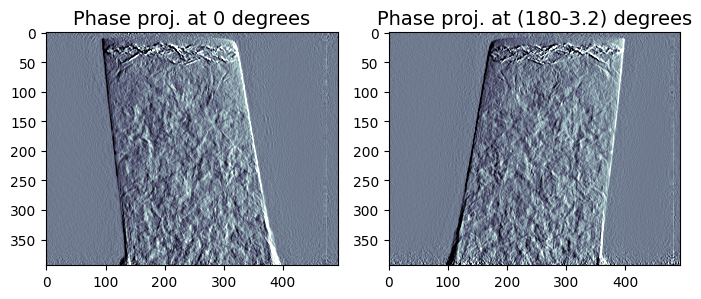

In [5]:
plt.close('all')
fig1 = plt.figure(1,figsize=(7,3))
ax1 = fig1.add_subplot(121)
im1 = ax1.imshow(projections[0],cmap='bone',vmin=-0.15,vmax=0.15)
ax1.set_title('Phase proj. at 0 degrees',fontsize = 14)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig1.colorbar(im1,cax=cax)
ax2 = fig1.add_subplot(122)
im2 = ax2.imshow(projections[-1],cmap='bone',vmin=-0.15,vmax=0.15)
ax2.set_title('Phase proj. at (180-3.2) degrees',fontsize = 14)
plt.tight_layout()
display.display(plt.gcf())
display.clear_output(wait=True)

### The tomographic reconstruction
Congratulations! You finally arrive to the tomographic reconstruction step of the entire volume.

<span style="color:red">**Warning: This part is time and memory consuming**</span>. This could be optimized by, for example, implementing the reconstruction on a GPU card or distributing the reconstruction of a group of slices accross different CPU cores. Since our goal here is learning, we will stick to the reconstruction using a CPU only.

In [6]:
# import the toupy routines we will need
from toupy.tomo import full_tomo_recons

Let us create a dictionary of parameters:

In [7]:
params = dict() # initializing dictionary
params["slicenum"] = 200  # Choose the slice for the initial reconstruction
params["filtertype"] = "ram-lak" # options: `ram-lak`, `shepp-logan`, `cosine`, `hamming`,`hann`, None (no filter).
params["freqcutoff"] = 1.0  # Frequency cutoff (between 0 and 1)
params["circle"] = True 
params["algorithm"] = "FBP"  # FBP or SART
params["derivatives"] = True  # To use the derivatives of the projections
params["calc_derivatives"] = False  # Calculate derivatives if not done
params["cliplow"] = None  # clip air threshold
params["cliphigh"] = -1e-4  # clip on sample threshold
params["autosave"] = False
params["vmin_plot"] = None  # 0.5e-5
params["vmax_plot"] = -1e-4  # None
params["colormap"] = "bone"
params["showrecons"] = False  # to display the reconstructed slice on the fly.

And now, we start the reconstruction:

Calculating a slice for display
Calculation done. Time elapsed: 0.57 s


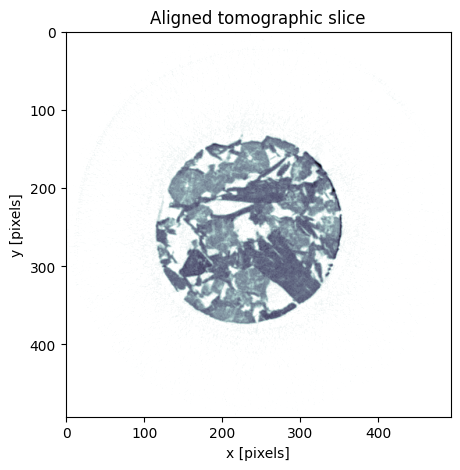

The total number of slices is 394


Do you want to start the full reconstruction? ([y]/n):  y


 ######################################## [100.00%]   394/  394


In [8]:
tomogram = full_tomo_recons(projections, theta, **params)

#### Orthogonal view of the reconstructed volume
Let us display three orthogonal view of the reconstructed volume

In [9]:
# third packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# import the toupy routines we will need
from toupy.utils import convert_to_delta, progbar

The gray level of the reconstructed slices are given in units of phase-shifts. Let us now convert phase-shifts to $\delta$ , where $\delta$ is the refractive index decrement and the refractive index is $n=1-\delta+i\beta$.

In [10]:
nslices, nr, nc = tomogram.shape
energy = 12.4e-10/wavelen
voxelsize = pixsize
print(f"The energy of the incident photons is {energy:.02f} keV")
print(f"The voxel size of the reconstructed volume is {voxelsize/1e-9:.02f} nm")
print(f"The dimensions of the reconstructed volume is {tomogram.shape} (height,width,depth)")

The energy of the incident photons is 6.20 keV
The voxel size of the reconstructed volume is 28.64 nm
The dimensions of the reconstructed volume is (394, 493, 493) (height,width,depth)


In [11]:
params["slicenum"] = 150
params["vmin_plot"] = 2e-6  # None
params["vmax_plot"] = 2e-5  # 5e-4
params["scale_bar_size"] = 2  # in microns
params["scale_bar_height"] = 0.4
params["scale_bar_color"] = "yellow"
params["bar_start"] = [20, 70]
params["bar_axial"] = [70, 100]  # [cols,rows]
params["colormap"] = "bone"
params["interpolation"] = "nearest"

Conversion of the gray-level of the slices from phase-shifts to delta:

In [12]:
# loop over the tomogram
for ii in range(nslices):
    strbar = "Slice {} out of {}".format(ii + 1, nslices)
    tomogram[ii], factor = convert_to_delta(tomogram[ii], energy, voxelsize)
    progbar(ii + 1, nslices, strbar)
print("\r")

 ######################################## [100.00%] Slice 394 out of 394


Preparing the Sagital, Coronal, and Axial slices:

In [13]:
# text style for the scale bar text
textstr = r"{} $\mu$m".format(params["scale_bar_size"])

# sagital slice
slicesag = np.s_[:, np.round(nr / 2).astype("int"), :]
sagital_slice = tomogram[slicesag]
# coronal slice
slicecor = np.s_[:, :, np.round(nc / 2).astype("int")]
coronal_slice = tomogram[slicecor]
# axial slice
axial_slice = tomogram[params["slicenum"]]

Displaying:

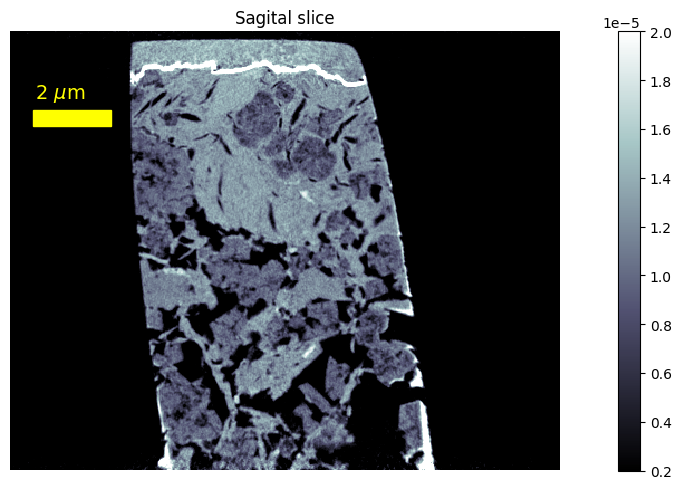

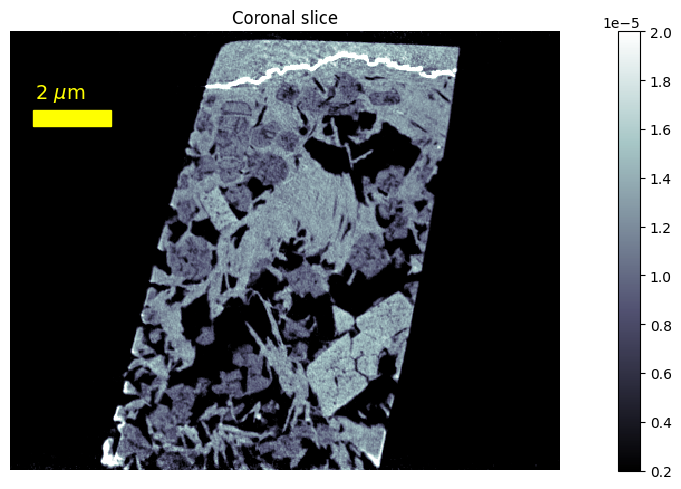

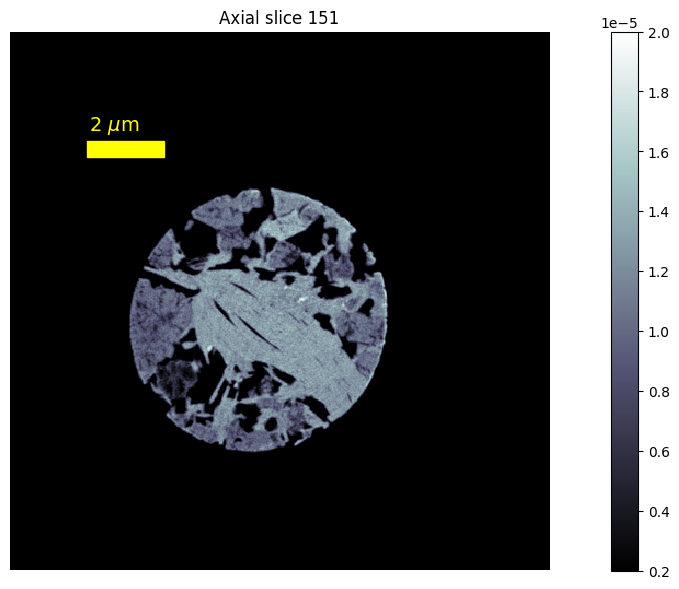

In [14]:
# display the figures
%matplotlib inline
##### Sagital slice
figsag = plt.figure(num=1, figsize=(12,5))
axsag = figsag.add_subplot(111)
imsag = axsag.imshow(
    sagital_slice,
    interpolation=params['interpolation'],
    cmap=params["colormap"],
    vmin=params["vmin_plot"],
    vmax=params["vmax_plot"],
)
figsag.colorbar(imsag)
axsag.set_title("Sagital slice")
axsag.text(
    params["bar_start"][0] + 2,
    params["bar_start"][1] - 5,
    textstr,
    fontsize=14,
    verticalalignment="bottom",
    color=params["scale_bar_color"],
)
rectsag = patches.Rectangle(
    (params["bar_start"][0], params["bar_start"][1]),  # (x,y)
    (np.round(params["scale_bar_size"] * 1e-6 / voxelsize)),  # width
    (np.round(params["scale_bar_height"] * 1e-6 / voxelsize)),  # height
    color=params["scale_bar_color"],
)
axsag.add_patch(rectsag)
axsag.set_axis_off()
plt.tight_layout()
#display.display(plt.gcf())
#display.clear_output(wait=True)

###### Coronal slice
figcor = plt.figure(num=2, figsize=(12,5))
axcor = figcor.add_subplot(111)
imcor = axcor.imshow(
    coronal_slice,
    interpolation=params['interpolation'],
    cmap=params["colormap"],
    vmin=params["vmin_plot"],
    vmax=params["vmax_plot"],
)
figcor.colorbar(imcor)
axcor.set_title("Coronal slice")
axcor.text(
    params["bar_start"][0] + 2,
    params["bar_start"][1] - 5,
    textstr,
    fontsize=14,
    verticalalignment="bottom",
    color=params["scale_bar_color"],
)
rectcor = patches.Rectangle(
    (params["bar_start"][0], params["bar_start"][1]),  # (x,y)
    (np.round(params["scale_bar_size"] * 1e-6 / voxelsize)),  # width
    (np.round(params["scale_bar_height"] * 1e-6 / voxelsize)),  # height
    color=params["scale_bar_color"],
)
axcor.add_patch(rectcor)
axcor.set_axis_off()
plt.tight_layout()
#display.display(plt.gcf())
#display.clear_output(wait=True)

###### Axial slice
figaxial = plt.figure(num=3, figsize=(16,7))
axaxial = figaxial.add_subplot(111)
imaxial = axaxial.imshow(
    axial_slice,
    interpolation=params['interpolation'],
    cmap=params["colormap"],
    vmin=params["vmin_plot"],
    vmax=params["vmax_plot"],
)
figaxial.colorbar(imaxial)
axaxial.set_title("Axial slice {}".format(params["slicenum"] + 1))
axaxial.text(
    params["bar_axial"][0] + 2,
    params["bar_axial"][1] - 5,
    textstr,
    fontsize=14,
    verticalalignment="bottom",
    color=params["scale_bar_color"],
)
rectaxial = patches.Rectangle(
    (params["bar_axial"][0], params["bar_axial"][1]),  # (x,y)
    (np.round(params["scale_bar_size"] * 1e-6 / voxelsize)),  # width
    (np.round(params["scale_bar_height"] * 1e-6 / voxelsize)),  # height
    color=params["scale_bar_color"],
)
axaxial.add_patch(rectaxial)
axaxial.set_axis_off()
#display.display(plt.gcf())
#display.clear_output(wait=True)

In [15]:
outputfname = "PXCTtomogram.npz"
np.savez(outputfname, wavelen = wavelen, energy=energy, voxelsize = voxelsize, tomogram_delta = tomogram)

In [16]:
!ls -lrth

total 7030784
-rw-r--r--  1 julio  staff   2.0G Feb 18  2021 PXCTprojections.npz
-rw-------  1 julio  staff    11K Jun 15  2023 PXCT_pipeline_extra.ipynb
-rw-------  1 julio  staff   517M May  9 10:21 PXCTcorrprojections.npz
-rw-r--r--  1 julio  staff    19K May  9 10:21 PXCT_pipeline_part1.ipynb
-rw-r--r--  1 julio  staff   333M May  9 10:44 PXCTalignedprojections.npz
-rw-------  1 julio  staff   147M May  9 10:44 PXCT_pipeline_part2.ipynb
-rw-------  1 julio  staff   561K May  9 10:48 PXCT_pipeline_part3.ipynb
-rw-r--r--  1 julio  staff   365M May  9 10:49 PXCTtomogram.npz
